In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastai.vision.all import *
from fastbook import *
import numpy as np

matplotlib.rc('image', cmap='Greys')

Under the Hood : Mnist Digit Classifier

Here we build a model from scratch using the Mnist dataset. We see how to use numpy arrays and tensors, application of broadcasting to them, , Calculating gradients, Definintion and choice of a loss function2, Updating of the weights using Stochastic Gradient Descent and the role of mini btaches.

We finally put all the math together to build a simple neural network to classify images

Download Mnist dataset
First we start by downloading the dataset

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
#hide
Path.BASE_PATH = path

In [ ]:
path.ls()

For the initial example, we choose to work with a subset of data to be specific we initially build a classfier to check whether an image is a 3 or 7.


In [ ]:
(path/'train/3').ls()

(#6131) [Path('train/3/27784.png'),Path('train/3/37042.png'),Path('train/3/27644.png'),Path('train/3/22149.png'),Path('train/3/57149.png'),Path('train/3/18805.png'),Path('train/3/51388.png'),Path('train/3/45271.png'),Path('train/3/34364.png'),Path('train/3/50679.png')...]

# Baseline Model

## Pixel Similarity
For our baseline model, we shall use the idea of pixel similarity.
Here we find the average pixel values for every pixel position for all image groups of 3 and 7 giving us two group averages,One representing the threes and another the sevens.
This defines what we may call the "ideal" 3 and 7.

To classfify an image as a 3 or 7, we see which of these two ideal digits the image is most similar to.
We then choose an abitrairy number and measure the distance between that and our two classfication choices.

### Group averages for 3 and 7

To do this, we need to stack all the images in a folder into one tensor.

We shall use the 3's for illustration.
To stack the images, first we create a python list containing all the threes in the 3 folder.

new_list = [f(0) for o in a_list if o>1].
This returns every element in **a_list** that is **greater than 1** after applying function, **f**.

To calculate the average for each pizel position for all images, we have to combine the images into a single 3d tensor by stacking up the individual tensors in a collection into a single tensor.

PyTorch has a stack function which we can use to do this.
Some operations such as taking mean require inputs to be floats, so we cast our stacked tensor to float by typing the name of the type we want to cast to and treating it as a method.

Generally, when images are floats, the pixel values are expected to be between 0 and 1.

Finally we can compute the mean / average values for each pixel position. We do this by taking the mean of the stacked image tensor alongside dimension 0 of our stacked 3d tensor which indexes over all images.

Once we are done getting our ideal digits. We pick an abitrary 3 and measure the distance from the ideal digits.

### **Measuring distance**

How do we measure the distance from an abitrary 3 to the ideal digits?

If we just add up the differences between the pixels of the abitrary image and the ideal image. we find that some differences are positive while others are negative.

This causes the differences to cancel themselves out, resulting in an image that is too light or dark in some places being shown as having zero difference from the ideal.

To counter this, data scientist generally measure distance in this context.





1. L1 norm where we take the mean of the absolute value of differences (the absolute value is the function which replaces negative values with positive values ). This is called the mean absolute difference or L1 norm.

In [ ]:
dist_sample_3_abs = (sample_3 - mean3).abs().mean()
dist_sample_7_abs = (sample_3 - mean7).abs().mean()

In [ ]:
dist_sample_3_abs, dist_sample_7_abs

(tensor(0.1114), tensor(0.1586))

2. L2 Norm or Root mean square error, here we take the mean of the square differences (which makes everything positive), we then take the square root to undo the squaring.

In [ ]:
dist_sample_3_sqrt = ((sample_3 - mean3)**2).mean().sqrt()
dist_sample_7_sqrt = ((sample_3 - mean7)**2).mean().sqrt()

In [ ]:
dist_sample_3_sqrt, dist_sample_7_sqrt

(tensor(0.2021), tensor(0.3021))

In both cases, the distance between our abitrary 3 and the ideal 3 is less than than the distance to the ideal 7.
PyTorch provides both the L1 and L2 Norm as loss functions which you can import as F from torch.nn.functional
Mse penalizes bigger mistakes more than L1 norm while being more lenient with small mistakes.

In [ ]:
#from torch.nn.functional import F

In [ ]:
F.l1_loss(sample_3.float(),mean3),F.l1_loss(sample_3.float(),mean7)

(tensor(0.1114), tensor(0.1586))

In [ ]:
F.mse_loss(sample_3,mean3).sqrt(), F.mse_loss(sample_3,mean7).sqrt()

(tensor(0.2021), tensor(0.3021))

## NumPy Array and PyTorch Tensor data structures

In [ ]:
#qfinal
threes = (path/'train/3').ls().sorted()
sevens = (path/'train/7').ls().sorted

im3 = Image.open(threes[0])
im7 = Image.open(sevens[0])

im3_tens = tensor(im3)
show_image(im3_tens)

im3_tens_df = pd.DataFrame(im3_tens)
im3_tens_df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

three_tensors = [tensor(Image.open(o) for o in threes)]
seven_tensors = [tensor(Image.open(0) for o in sevens)]

show_image(three_tensors[0])

stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)

show_image(mean3)

#measuring distance between random input and ideal 3, mean 3
#L1 norm or L2 norm
a_3 = stacked_threes[1]
a_7 = stacked_sevens[1]

L1_threes = (a_3 - mean3).abs().mean()
L1_sevens = (a_7 - mean3).abs().mean()

L2 = ((a_3 - mean3)**2).mean().sqrt()

#pytorch provides both these loss functions inside torch.nn.functional
F.l1_loss(a_3.float,mean3), F.mse_loss(a_3,mean3).sqrt()
F.mse_loss(sample_3,mean3).sqrt(), F.mse_loss(sample_3,mean7).sqrt()



Python is a slow language compared to most, anything fast in PyTorch is probably a wrapper of an object written, compiled and optimized in another language, usually C.
C is a low level programming language, which is very fast compared to python.

A NumPy array is a multidimensional table of data of the same type. This can be any type i.e. a list, matrix, cube or even an array of arrays (jagged array).
If items are all of some simple type e.g. int, floats etc., NumPy arrays can be stored as compact c data structures in memory.
NumPy has a wide variety of operators and methods it can use to perform computation on these data structures at the same speed optimized C which is a multitude faster than Python. This is because they are written in optimized C.

A PyTorch tensor is nearly the same thing as a numpy array, with the exception that the tensor can only be of a basic numerical type / simple type such as int, float etc for example a PyTorch tensor cannot be a jagged array, it will always be a multidimensional rectangular structure.

PyTorch tensor can also live on GPU, and are also optimized for GPU, meaning it can perform faster computations given lots of values to work with.
PyTorch also supports calculating gradients which is crucial for machine learning as our loss function, weight optimizations are calculated based of the gradients.
It would be impossible to do machine learning without this ability.

In [21]:
#Define list object
dataSet = [[1,2,3],[4,5,6]]
dataSet

[[1, 2, 3], [4, 5, 6]]

In [22]:
#convert python object to an array
dataSetArray = array(dataSet)
dataSetArray

array([[1, 2, 3],
       [4, 5, 6]])

In [23]:
#convert python object to a tensor
dataSetTensor = tensor(dataSet)
dataSetTensor,dataSetTensor[0],dataSetTensor.type()

(tensor([[1, 2, 3],
         [4, 5, 6]]),
 tensor([1, 2, 3]),
 'torch.LongTensor')

In [24]:
dataSetTensor + 1

tensor([[2, 3, 4],
        [5, 6, 7]])

## Computing Metrics Using Broadcasting

Remember above, we have a baseline model that tells us how if a number is a 3 or 7. To do machine learning we need to know how good that model is, to do this we define a metric which is just a number that tells us how good our model is. We do this using the correct labels of the data and the predictions of the model.
We want to calculate our metric based on the validation set, as this data has not been seen by the model during training. Calculating our metric based of our training set will inadvertently lead to the model overfitting on the train set which results in poor results when the model sees new data.
Our baseline model has no training component, hence this doesn't matter but nonetheless we shall go ahead and use the validation set as a best practice.To do this we follow the same steps we did to define the training set as shown below.

We already have a value for the ideal 3 and 7, so we define a stacked tensor containing all the sevens and threes respectively in the validation set.
To calculate the distance from the ideal 7 or 3 for the whole dataset, we subtract each image from the ideal 3 just like we did for the individual image.
Broadcasting allows us to do calculations on tensor of different shapes.

In [ ]:
#We stack the sevens and threes in one tensor

#qfinal
valid_threes = (path/'valid/3').ls().sorted()
valid_sevens = (path/'valid/7').ls().sorted()

valid_three_tensors = [tensor(Image.open(o) for o in valid_threes)]
valid_seven_tensors = [tensor(Image.open(0) for o in valid_sevens)]

valid_stacked_threes = torch.stack(valid_three_tensors).float()/255
valid_stacked_sevens = torch.stack(valid_seven_tensors).float()/255

We create a function mnist_distance that calculates the l1 norm/mean absolute error.

In [ ]:
def mnist_distance(a,b):
    (a-b).abs().mean((-1,-2))

#this should give us the same result as L1_threes calculated above
mnist_distance(a_3,mean3), L1_threes

In [ ]:
valid_stacked_threes.shape(),mean3.shape()

In [ ]:
#Here the distance to the ideal image 3 from every single image in the dataset is calculated.
valid_threes_dist = mnist_distance(valid_stacked_threes, mean3)
valid_threes_dist

When we perform a simple calculation such as (a-b) on two tensors of different ranks, Broadcasting expands the smaller tensor in memory, to have the same size as the larger tensor.
It results in a value for every image expressed as a rank 1 tensor of 1,010 different values, the number of 3's in our dataset.After broadcasting , PyTorch does it usual element wise subtraction.Lets take an example


In [ ]:
tensor([1,2,3]) + tensor(1) 

This results in tensor([2,3,4]) which looks like an element wise addittion. PyTorch in this case treats tensor(1) as if it were three copies of the same tensor.Similary mean3, a rank 2 tensor representing a single image is treated as if it were 1,010 copies of the same image. It then subtracts each copy from an image in our valid_threes_dist calculating the distance between every 3 in the validation set and the ideal 3 resulting in 1,010 different values.

When PyTorch performs broadcasting, it doesnt actually copy the image 1,010 times. It just pretends that a tensor is of that shape but it doesnt actually allocate any memory for this.
PyTorch performs the whole computation in c code, and CUDA on GPU which is just C for GPU resulting in performance thousands of times faster than using pure python and millions of times faster on GPU.
This is true of all broadcasting and element wise operations and functions done in PyTorch.

Next in our function, we see .abs() which applies the method to every resulting element in a tensor returning a tensor that contains 1,010 absolute values.
Then finally we call .mean((-1,-2)) which contains a tuple of (-1,-2) which are a range of axes which represents the last and second last elements. This tells PyTorch that we want to take the mean ranging over values indexed by the last two axes of the tensor, which are the horizontal and vertical dimensions of an image. After this we are left with the first tensor axis which takes the mean over all images in the tensor, meaning we calculate the average intensity of all pixels for an image.

###is_3
We can use mnsit_distance defined above to check whether an image is a 3 or 7 by using the following logic, if the distance between the selected image and the ideal 3 is less than the distance to the ideal 7, then the number is a 3.
We define a function is_3 with the above logic

In [ ]:
def is_3(x):
    return (mnist_distance(x,mean3) < mnist_distance(x, mean7))

In [ ]:
#function returns true or false
is_3(a_3), is_3(a_3).float()

When converted to a float, True returns 1 and False returns 0. We can then run is_3 on the whole dataset.

In [ ]:
is_3(valid_stacked_threes)

Previously we used L1 normalization as a metric, but in practice we usually use metrics like accuracy that are easier to understand. We use the is_3 function over the whole dataset to calculate the accuracy by taking the average of the function for threes, and the inverse to calculate the accuracy for the sevens, as shown below.

In [ ]:
accuracy_3 = (is_3(valid_stacked_threes).float()).mean()
accuracy_7 = (1- (is_3(valid_stacked_sevens).float())).mean()
accuracy_3,accuracy_7,(accuracy_3 + accuracy_7)/2

This gives us the accuracy for all the threes. But in reality, 3 and 7 are quite similar, making it easy to classify between the two.
The model is trained to classify between 3 and 7 are also just two numbers out of 10.
To build a more robust model, we need to build a model that constantly improves, learns from the previous predictions and automatically improve itself.
To do this, we further explore the training process and Stochastic Gradient Descent (SGD).

Stochastic Gradient Descent

In 1962, Arthur Samuels described machine learning in his classic essay "Artificial Intelligence: A frontier of automation". Here he suggests that instead of telling a computer the exact steps need to solve a problem as in regular programming, we could just show a number of examples and let it figure out how to solve a problem itself. This indeed turned out to be a powerful idea, as was later shown.

Arthur Samuel's basic idea was 

Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.

This spells out some powerful concepts
- The idea of weight assignment
- The fact that weight assignment has some actual performance
- The idea that there needs to be an automatic means of testing
- The need for an automatic means of improving the performance by altering the weights

This is the key to building a model that continuously gets better, unfortunately our pixel similarity lacks a learning mechanism, meaning it cannot continuously get better. To take advantage of deep learning, we represent the problem in the form Arthur Samuels described above.
To do this, we use the concepts of weights, instead of calculating the distance between the pixels of an image and the ideal image, we assign weights to each pixel whereby the highest weights are associated with the pixels that are most likely to be black.
For example, if an image is a 7, the pixels in the bottom right corner are unlikely to be activated hence the pixels in the bottom right should have a low weight assignment for a 7 while if it was an 8 or a 9 say, the pixels would be activated hence they should have a high weight assignment for 8 or 9.
\n This can be represented as a function and a set of weight values for each category, for example the probability of being an 8 can be represented as below


In [1]:
def pr_eight(x,w):
    return (x*w).sum()

Here we assume that the x is an image with the rows stacked up into one line as a single tensor. w, represents the weights. With this we just need to update the weights in such a way that the model improves, we continuously improve the weights until we can't improve them any more, or we reach the selected number of epochs/iterations. We want the values of w to be high for numbers that are actually 8 and low for numbers that are not. With this just need to find the best weights for 8 to come up with the best function that can recognize 8's.

To find the above function into a machine learning classifier, we follow the specific steps
1. We initialize the weights
2. Using set weights, we calculate whether an image is a 3 or 7 and get predictions
3. Using predictions from step 2, we calculate our loss which tell us how good our predictions are
4. Based on the above loss, we calculate our gradients, which tell us how changing the weights affects the model
5. Based on above gradients, we change the weights in the direction that improves the model
6. Go back to step 2, and repeat the process
7. Iterate until you usually stop because the model is good enough, or you are tired of waiting 

These steps are illustrated as shown below 

In [ ]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')


There are several ways to perfrom the seven steps listed above, but they all follow some general guidelines
- initilize: we usually initialize the parameters to random values and because we have a means of automatically improving the weights, it means we shall iterate towards the correct weights no matter where we start at
- Loss : This refers to the means of testing the effectiveness of any current weight assignment in terms of actual performance such that the function returns a small number if the performance is good.
- Step, how do we know if we are taking the step in the right direction, we can try adjusting the loss in any direction and see if the loss goes up and down, with this we have the direction, then we take a step in the direction using different intensities until we find which amount works best.
  Calculating gradients gives us an exact direction and number in which to adjust our weights.

lets illustrate the above steps with a simple toy example where we define a quadratic as a simple loss function and x as the weight parameter.


In [1]:
def f(x):
    return x**2

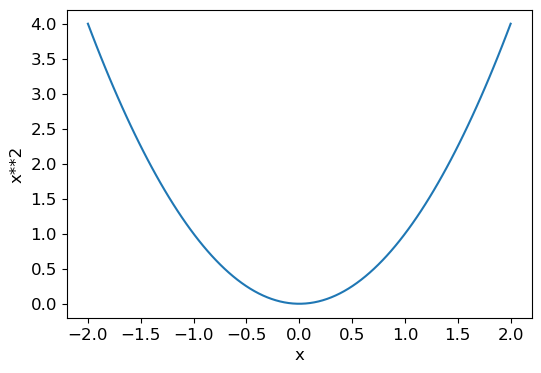

In [6]:
#Lets plot the following equation
#help(plot_function)
plot_function(f, 'x', 'x**2')

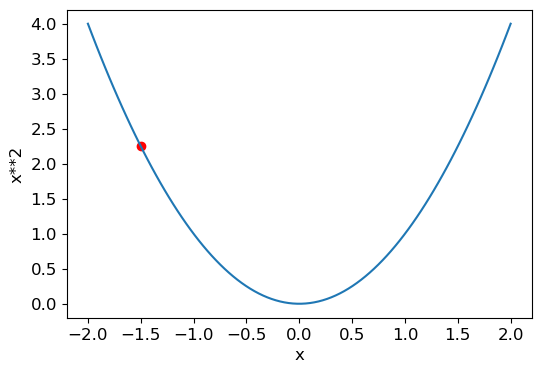

In [14]:
#As per steps above, we pick a random parameter value of -1.5 and calculate the loss.
#f(-1.5)

plot_function(f, 'x', 'x**2')
plt.scatter(-1.5,f(-1.5), color="red")

We continously adjust our model in the direction of the slope until it reasches the lowest point.We can calculate the adjustment number using gradients whcih tell us how far to adjust the weights to improve performance.

Gradients

Calculus tells us how much our loss will go up or down when we adjust our parameter values up or down.
A derivative of a function tells us about the rate of change of a function not the function value.
Remember that a function usually has a bunch of gradients, here we calculate the gradient for each weight while taking the rest as constant, then repeat this for each weight.

PyTorch can automatically calculate gradients for us but first lets pick a value where you want to calcualte derivatives of

In [16]:
#this tells pytorch to calculate gradients with respect to a variable at the value,3
#x values
xt = tensor(3.).requires_grad_()

In [17]:
#yt prints out the values and the gradient function it uses to calculate gradients when asked to
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [18]:
#backward pass/ backpropagtion where we calculate the drivatives
yt.backward()

In [19]:
#We can view the gradient by calling the grad attribute of our input tensor
xt.grad

tensor(6.)

The derivative of x**2 is 2*x, hence 2*3 results in 6 as shown above.Lets do the same for multiple values.

In [25]:
xt = tensor([3.,4.,5.]).requires_grad_()
xt

tensor([3., 4., 5.], requires_grad=True)

We redefine our function f(x) adding sum so the function takes a vector rank 1 tensor and converts into a scalar 0 rank tensor

In [28]:
def f(x):
    return (x**2).sum()

yt = f(xt)
yt

tensor(50., grad_fn=<SumBackward0>)

In [29]:
yt.backward()

In [30]:
xt.grad

tensor([ 6.,  8., 10.])

This gives us the slope of a function, they dint actually tell us how far to adjust the parameters but it gives us an idea, large slope means we still have alot of adjustment to do while a small slope means we are closer to the optimum value.

Stepping with learning rate

This involves changing the weights/parameters based on the gradients. It is commonplace to multiply the 

Stochastic Gradient Descent

According to Arthur Samuels, if we can find automatic means of testing the effectiveness of weight assignments in terms of actual performance and have a mechanism to automatically adjust the weight assignment in such a way that maximises the performance.This results in a machine that learns from experience which is the key to building models that keep getting better.

Our pixel approach doesnt get better and better, First off there is no weight assignment meaning there is no means of automatically testing the performance of weight assignment hence no way to adjust weight assignment so as to improve performance i.e. we cant improve performace by adjusting the parameters.

Instead of using our pixel similarity approach, we could instead assign each individual pixel in an image weights such that pixels that are likely to be black are associated with the highest weight assignment and vice versa.
For example pixels in the bottom right corner are not likely to be activated for a 7 hence they should have a low weight for a 7 but are likely to be activated for a 2 hence they should have a high weight asssignment for a 2.

This can all be represented as a function and a set of weight for each possible category for example the probability of being a 2 can be rerpresented as 

In [2]:
def pr_two(x,w):
    return (x*w).sum

Here we are assuming that x is an image represented as a vector i.e. all the rows are stacked up in a long line.
Vector w represents the weights. From here we need a way to adjust weights in such a way that maximizes performance and makes them a little better. With this approach we have a model that continously improves

We are trying to find weights w that causes the function result to be high for an images that are actually 2 and low for images that are not

Summed up, these are the steps to turn the function into a digit classifier
1. Assign/Initialize weights
2. For each image, make a prediction whether it is a 3 or 7.
3. Calculate how good a model is with initial weights i.e. calculate the loss
4. Based of the loss,calculate the gradients which lets us know which direction and by how much to adjust the weights so as to improve performance.
5. Based on gradients, adjust the weights
6. Go back to step 2
7. Repeat until you need to stop

The above steps are the key to training all deep learning models. Amazing to see that such a simple approach really does solve complex problems

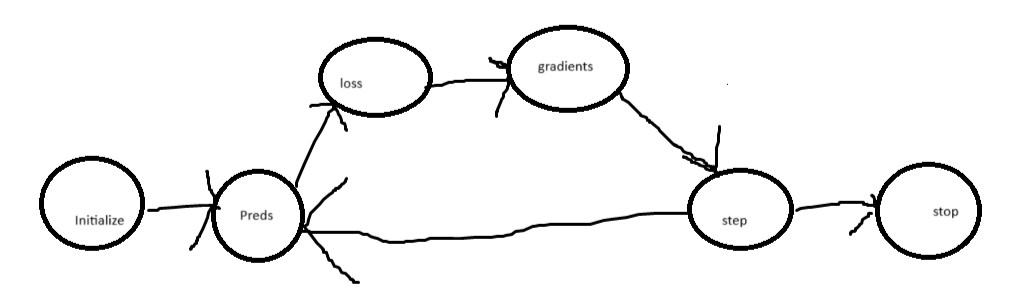

There are multiple ways to do the above seven steps and these details make a big difference for deep learning practioners, but it turn out that some of the steps follow some general priciples i.e.
- Initialize: We usually initialize the model with some random initial weights. Choosing random weights works just fine since we are contioulsly improving the model.
- Loss: This is what Arthur Samuel referred to when he was talking of an automatic ways of testing the weight assignment in terms of actual performance. We need a function that returns a small number when the model performance is good (The convention is to treat a small loss as good and a large loss as bad, though as mentioned this is just a convention)
- Step: Calculus allows us to determine which direction and by how much exactly to adjust our weight assignment in.This is through calculating gradients. A manual way of doing this would be to adjust the weights and see which direction maximizes performance giving you the direction. Once you have that you can adjust by large and small values until you come to an optimal value.We get exactly the same results as using gradients.
- Stop: Once we have decided when to stop training here is where you apply that decision. For a digit classifier this would probably be when the loss starts getting worse or we ran out of time.

#use case
Before applying the following model to our image classification task at hand, lets first describe a simple use case showcasing above steps

## Mnist Loss

concat all images into a single tensor. Change from matrix to vector using .view()


In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1,28*28)

We need a label for each image. we use 1 for 3 and 0 if it is a 7.

In [ ]:
train_y = tensor([1]*len(sevens) + [0]*len(threes)).unsqueeze(1)

In [ ]:
train_x.shape, train_y.shape

A dataset is supposed to return a tuple of (x,y) when indexed. We use pythons zip function combined with a list to get this functionality

In [ ]:
dset = list(zip(train_x,train_y))

In [ ]:
valid_x = torch.cat([val_stacked_threes,val_stacked_sevens]).view(-1,28*28)
valid_y = tensor([1]*len(valid_threes) + [0]*len(valid_sevens)).unsqueeze(1)
val_dset = list(zip(valid_x,valid_y))

In [ ]:
valid_x.shape,valid_y.shape

### Seven steps

#### Initialize Parameters

In [ ]:
def init_params(size,std=1.0):
    return torch.randn((size)*std).requires_grad_()

In [ ]:
weights = init_params((28*28,1))

In [ ]:
bias = init_params(1)

In [2]:
#from y = wx + b where w is the weights
#we add bias as wx can be 0 when pixels equals 0
#single prediction
prediction = (train_x[[0]*weights.T).sum + bias

In [ ]:
#in python matrix multiplication is represented using an @
#batch@weights + bias
def linear1(xb):
    return xb@weights + bias

In [ ]:
one_prediction = linear1(train_x[0])

In [ ]:
preds = linear1(train_x)
preds

Accuracy

#### Loss function

The loss function receives argument preds as input, with each value being between 0 and 1 where each value is the prediction that an image is a 3.

Lets create another argument for trgts with each value being 1 when it is a 3 and vice versa.

Suppose we had 3 images with values being a 3, 7 and a 3.Suppose our model predicted with high confidence that our first image was a 1 (0.9) , with slight coinfidence that our 2nd image was a 7(0.4), and with fair confidence but incorrectly that the third was a 7.(0.2) meaning our loss function would receive the following values as input

In [ ]:
trgts = ([1,0,1])
prds = ([0.9,0.4,0.2])

Below we build a loss function that measures distance from the targets

torch.where(a,b,c) is the same as running the list comprehension [b[i] if a[i] is true else c[i] for i in range(len(a))]

In [ ]:
#function will measure distance from 1 if target is 1 and distance from 0 if target is 0
def mnist_loss(predictions, targets):
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

In [ ]:
#loss function should return a lower number when the predicton is correct, when accurate predictions are more confident and a higher number when the prediction is false.
torch.where(trgts == 1, 1- prds, prds)

In [ ]:
#this gives us a scalar for loss by taking the mean of the previous tensor
mnist_loss(trgts, prds)

In [ ]:
#say we change the 0.2 to 0.8 giving a more accurate predicition for the 7, i.e. 0.8 says it is highly unlikely the 3rd float in the tuple is 7
#this results in a smaller loss, meaning this is a better prediction
mnist_loss(tensor([0.9,0.4,0.8]), trgts)

One potential issue with the mnist_loss currenlty defined we assume all the preds are between 0 and 1, we need to then ensure that this is always the case. We can do this using a sigmoid function.

#### Sigmoid

This function always outputs a number between 0 and 1.It takes any input value negative or positive and squeeshes it into an output value between 0 and 1.It can be defined as follows

In [1]:
def sigmoid(x):
    return 1/(1 + torch.exp(-x))

so we update our mnist_loss to include sigmoid

In [ ]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return (torch.where(targets==1, 1 - predictions, predictions))

- A metric is to drive human understanding and a loss function is to drive automated learning

Mini batches

In order to take an optimization step, we need to calculate the loss over one or more data items.Calculating the loss for one single item gives too little information to build a model for all items as the model being built would be optimized for that item whereas using all items in the dataset would take too long.

As a compromise, we take the average loss of a few data items at a time. This is called a mini batch. The number of data items in a mini batch is refered to as the batch size. and proic
A larger batch size means you will get more accurate and stable estimate of our parameter gradients from the loss, but it also takes longer and processes fewere mini batches per epoch.

Another reason for getting the gradients of parameters in mini batches as opposed to for single data items is the use of accelerated compute like GPU's which only perform well when fed many data items to work with but if you feed them to much data at once they run out of memory.

If you remember in the production chapter, we get better generalization when we vary the items we show the network when training. Hence on simple and effective thing we can do is vary the items in each mini batch. To do this rather than simply enumerating our dataset in order for every epoch, we randomly shuffle the dataset on every epoch before choosing a mini batch.
PyTorch and fastai provide a class for you called a DataLoader that does the shuffling and mini batch collation. A DataLoader can take any python collection and turn it into an iterator over mini batches for example

In [ ]:
coll = range(15)
dl = DataLoader(coll, batch_size = 5, shuffle=True)
list(dl)

Putting it all together

In [ ]:
#We want to create a loop like this
for x,y in dl:
    pred = model(x)
    loss = loss_func(preds,y)
    loss.backwards()
    params.data -= params.grad * lr

In [ ]:
#step 1 
#initialize parameters
weights = init_params(28*28,1)
bias = init_params(1)

In [ ]:
#create dataloader
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

In [ ]:
#create mini batch
batch = train_x[:4]
batch.shape

In [ ]:
#make preds
preds = linear1(batch)
preds

In [ ]:
#calculate loss
loss = mnist_loss(preds, train_y[:4])
loss

In [ ]:
#calculate gradients
loss.backwards()
weights.grad.shape, weights.grad.mean(), bias.grad

Lets put the prediction, loss and gradient part in a function

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [ ]:
calc_grad(batch,train_y[:4], linear1)
weights.grad.mean(),bias.grad

loss.backward() actually adds up the gradients of loss to any other gradients that are stored.Because of this we usually set our weights and bias to 0.

In [ ]:
weights.grad.zero_()
bias.grad.zero_();

Our remaining step is to update our weights and biases based of the gradient values.When doing this we have to tell PyTorch not to take the gradient of this step too otherwise things get confusing when we try to take the derivative at the next step.The data attribute of a tensor signals PyTorch not to calculate gradients at a particular step.

In [3]:
#training loop for an epoch
def train_epoch(model, lr, params):
    for x,y in dl:
        calc_grad(xb,yb,model)
        for p in params:
            p.data -= p.grad.lr
            p.grad.zero_()

In [ ]:
(preds>0.0).float() == train_y[:4]


In [ ]:
#step